dataset upload.


In [1]:
from google.colab import files
uploaded = files.upload()


Saving data.zip to data.zip


In [2]:
!unzip data.zip


Archive:  data.zip
   creating: data/host/
  inflating: data/host/000002.png    
  inflating: data/host/000003 (3).png  
  inflating: data/host/000003 (4).png  
  inflating: data/host/000009 (3).png  
  inflating: data/host/000009 (4).png  
  inflating: data/host/000010.png    
  inflating: data/host/000015.png    
  inflating: data/host/000016 (3).png  
  inflating: data/host/000016 (4).png  
  inflating: data/host/000017.png    
  inflating: data/host/000018 (2).png  
  inflating: data/host/000019 (3).png  
  inflating: data/host/000019 (4).png  
  inflating: data/host/000020 (3).png  
  inflating: data/host/000020 (4).png  
  inflating: data/host/000021.png    
  inflating: data/host/000023 (2).png  
  inflating: data/host/000024 (2).png  
  inflating: data/host/000026 (2).png  
  inflating: data/host/000026.png    
  inflating: data/host/000027 (2).png  
  inflating: data/host/000027.png    
  inflating: data/host/000029 (5).png  
  inflating: data/host/000029 (9).png  
  inflating

In [ ]:
import cv2
import numpy as np
import pywt
import torch
import torch.nn as nn
import os


In [ ]:
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    return img.astype(np.float32) / 255.0


In [ ]:
def embed_watermark(host, watermark, alpha):
    coeffs = pywt.dwt2(host, 'haar')
    LL, (LH, HL, HH) = coeffs

    wm = cv2.resize(watermark, LH.shape[::-1])

    LH_emb = LH + alpha * wm
    HL_emb = HL + alpha * wm

    return pywt.idwt2((LL, (LH_emb, HL_emb, HH)), 'haar')


In [ ]:
def extract_watermark(wm_img, host, alpha):
    c1 = pywt.dwt2(host, 'haar')
    c2 = pywt.dwt2(wm_img, 'haar')

    LH1, HL1 = c1[1][0], c1[1][1]
    LH2, HL2 = c2[1][0], c2[1][1]

    wm = ((LH2 - LH1) + (HL2 - HL1)) / (2 * alpha)
    return np.clip(wm, 0, 1)


In [ ]:
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return 0.002 + self.net(x) * 0.018


In [ ]:
model = AlphaNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

HOST_DIR = "data/host"
WM_DIR = "data/watermark"

for epoch in range(30):
    total_loss = 0

    for h in os.listdir(HOST_DIR):
        host = load_gray(os.path.join(HOST_DIR, h))
        wm = load_gray(os.path.join(WM_DIR, np.random.choice(os.listdir(WM_DIR))), size=256)

        host_t = torch.tensor(host).unsqueeze(0).unsqueeze(0).cuda()

        alpha = model(host_t).item()

        wm_img = embed_watermark(host, wm, alpha)
        wm_ext = extract_watermark(wm_img, host, alpha)

        loss = np.mean((wm_ext - wm) ** 2)
        total_loss += loss

        optimizer.zero_grad()
        torch.tensor(loss, requires_grad=True).backward()
        optimizer.step()

    print(f"Epoch {epoch}: Loss = {total_loss:.6f}")


Epoch 0: Loss = 0.000000
Epoch 1: Loss = 0.000000
Epoch 2: Loss = 0.000000
Epoch 3: Loss = 0.000000
Epoch 4: Loss = 0.000000
Epoch 5: Loss = 0.000000
Epoch 6: Loss = 0.000000
Epoch 7: Loss = 0.000000
Epoch 8: Loss = 0.000000
Epoch 9: Loss = 0.000000
Epoch 10: Loss = 0.000000
Epoch 11: Loss = 0.000000
Epoch 12: Loss = 0.000000
Epoch 13: Loss = 0.000000
Epoch 14: Loss = 0.000000
Epoch 15: Loss = 0.000000
Epoch 16: Loss = 0.000000
Epoch 17: Loss = 0.000000
Epoch 18: Loss = 0.000000
Epoch 19: Loss = 0.000000
Epoch 20: Loss = 0.000000
Epoch 21: Loss = 0.000000
Epoch 22: Loss = 0.000000
Epoch 23: Loss = 0.000000
Epoch 24: Loss = 0.000000
Epoch 25: Loss = 0.000000
Epoch 26: Loss = 0.000000
Epoch 27: Loss = 0.000000
Epoch 28: Loss = 0.000000
Epoch 29: Loss = 0.000000


In [ ]:
MODEL_PATH = "/content/alpha_net.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved at", MODEL_PATH)


Model saved at /content/alpha_net.pth


In [ ]:
MODEL_PATH = "/content/alpha_net.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved at", MODEL_PATH)


Model saved at /content/alpha_net.pth


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import cv2
import numpy as np
import os
import torch

TEST_HOST = "/content/data/host"
TEST_WM = "/content/data/watermark"
OUT_DIR = "/content/results"
os.makedirs(OUT_DIR, exist_ok=True)

for hname in os.listdir(TEST_HOST):
    host = load_gray(os.path.join(TEST_HOST, hname), size=256)
    wm = load_gray(os.path.join(TEST_WM, np.random.choice(os.listdir(TEST_WM))), size=64)

    # Predict adaptive alpha
    host_t = torch.tensor(host).unsqueeze(0).unsqueeze(0).float().to(device)
    with torch.no_grad():
        alpha = model(host_t)[0, 0].cpu().numpy()

    # Embed watermark
    watermarked = embed_watermark(host, wm, alpha)

    # Extract watermark
    extracted = extract_watermark(watermarked, host, alpha)

    # Metrics
    p = psnr(host, watermarked, data_range=1.0)
    s = ssim(host, watermarked, data_range=1.0)

    print(f"{hname} → PSNR: {p:.2f}, SSIM: {s:.4f}")

    # Save images
    cv2.imwrite(f"{OUT_DIR}/host_{hname}", (host*255).astype(np.uint8))
    cv2.imwrite(f"{OUT_DIR}/wm_{hname}", (watermarked*255).astype(np.uint8))
    cv2.imwrite(f"{OUT_DIR}/ext_{hname}", (extracted*255).astype(np.uint8))


10 - Copy (2) - Copy.png → PSNR: 42.45, SSIM: 0.9732
7 (2) - Copy.png → PSNR: 42.00, SSIM: 0.9763
6 - Copy (2) - Copy.png → PSNR: 42.00, SSIM: 0.9799
8 (2) - Copy.png → PSNR: 42.45, SSIM: 0.9917
10 (2) - Copy.png → PSNR: 42.45, SSIM: 0.9733
7 - Copy (3).png → PSNR: 42.44, SSIM: 0.9763
8 - Copy - Copy.png → PSNR: 42.01, SSIM: 0.9911
10.png → PSNR: 42.45, SSIM: 0.9727
6 (2) - Copy.png → PSNR: 41.99, SSIM: 0.9643
10 - Copy - Copy.png → PSNR: 42.45, SSIM: 0.9730
11 - Copy (2).png → PSNR: 42.39, SSIM: 0.9878
11 - Copy - Copy.png → PSNR: 42.45, SSIM: 0.9879
8 - Copy (2) - Copy.png → PSNR: 42.45, SSIM: 0.9919
6 - Copy (3).png → PSNR: 41.99, SSIM: 0.9643
7.png → PSNR: 42.44, SSIM: 0.9763
7 (2).png → PSNR: 42.44, SSIM: 0.9763
000016 (3).png → PSNR: 42.01, SSIM: 0.9668
12 - Copy (2).png → PSNR: 42.43, SSIM: 0.9694
11 (2) - Copy.png → PSNR: 42.01, SSIM: 0.9867
8 - Copy.png → PSNR: 42.01, SSIM: 0.9911
6 (2).png → PSNR: 42.37, SSIM: 0.9681
6 - Copy.png → PSNR: 42.00, SSIM: 0.9799
000003 (4).png → P

In [ ]:
import torch
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlphaNet().to(device)
model.load_state_dict(torch.load("/content/alpha_net.pth", map_location=device))
model.eval()

print("✅ Model loaded")


✅ Model loaded


In [ ]:
from google.colab import files

print("Upload HOST image")
host_file = files.upload()

print("Upload WATERMARK image")
wm_file = files.upload()

host_path = list(host_file.keys())[0]
wm_path = list(wm_file.keys())[0]


Upload HOST image


Saving host.png to host.png
Upload WATERMARK image


Saving watermark.png to watermark.png


Predicted alpha: 0.011530894


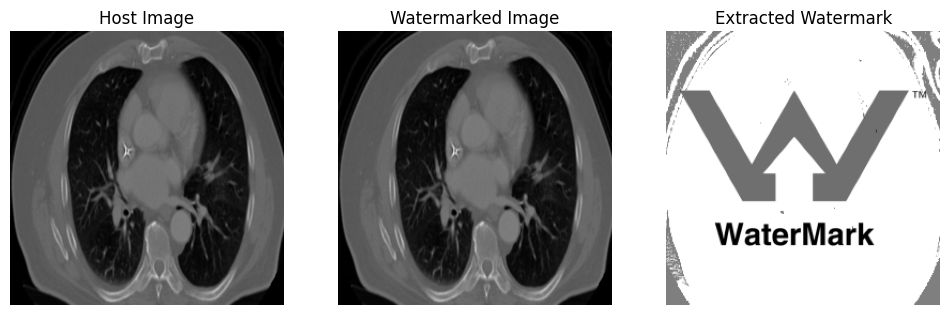

In [ ]:
# ===============================
# Watermarking Inference Code
# ===============================

import cv2
import numpy as np
import pywt
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

# -------------------------------
# Load AlphaNet model
# -------------------------------
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return 0.002 + self.net(x) * 0.018  # adaptive alpha between 0.002 and 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlphaNet().to(device)
model.load_state_dict(torch.load("/content/alpha_net.pth", map_location=device))
model.eval()

# -------------------------------
# Utility functions
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    return img.astype(np.float32) / 255.0

def embed_watermark(host, watermark, alpha):
    coeffs = pywt.dwt2(host, 'haar')
    LL, (LH, HL, HH) = coeffs

    wm = cv2.resize(watermark, LH.shape[::-1])
    LH_emb = LH + alpha * wm
    HL_emb = HL + alpha * wm

    wm_img = pywt.idwt2((LL, (LH_emb, HL_emb, HH)), 'haar')
    return np.clip(wm_img, 0, 1)

def extract_watermark(wm_img, host, alpha):
    c1 = pywt.dwt2(host, 'haar')
    c2 = pywt.dwt2(wm_img, 'haar')

    LH1, HL1 = c1[1][0], c1[1][1]
    LH2, HL2 = c2[1][0], c2[1][1]

    wm = ((LH2 - LH1) + (HL2 - HL1)) / (2 * alpha)
    return np.clip(wm, 0, 1)

# -------------------------------
# User Input: host image & watermark
# -------------------------------
host_path = "/content/data/host/000016 (3).png"        # change to your host image path
wm_path = "/content/data/watermark/watermark.png"  # change to your watermark image path

host = load_gray(host_path)
wm = load_gray(wm_path, size=host.shape[0])

# -------------------------------
# Predict adaptive alpha
# -------------------------------
host_t = torch.tensor(host).unsqueeze(0).unsqueeze(0).float().to(device)
with torch.no_grad():
    alpha = model(host_t)[0,0].cpu().numpy()
print("Predicted alpha:", alpha)

# -------------------------------
# Embed watermark
# -------------------------------
wm_img = embed_watermark(host, wm, alpha)

# -------------------------------
# Extract watermark
# -------------------------------
wm_ext = extract_watermark(wm_img, host, alpha)

# -------------------------------
# Display results
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Host Image")
plt.imshow(host, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Watermarked Image")
plt.imshow(wm_img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted Watermark")
plt.imshow(wm_ext, cmap='gray')
plt.axis('off')

plt.show()


Predicted alpha: 0.011530894
PSNR (Host vs Watermarked): 42.57
SSIM (Host vs Watermarked): 0.9596
NC (Watermark vs Extracted): 0.9917


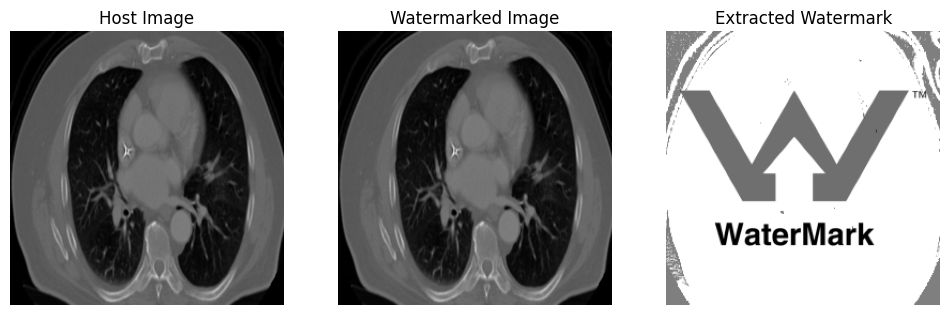

In [ ]:
# ===============================
# Watermarking Inference Code with Metrics (Fixed)
# ===============================

import cv2
import numpy as np
import pywt
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# -------------------------------
# Load AlphaNet model
# -------------------------------
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return 0.002 + self.net(x) * 0.018  # adaptive alpha between 0.002 and 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlphaNet().to(device)
model.load_state_dict(torch.load("/content/alpha_net.pth", map_location=device))
model.eval()

# -------------------------------
# Utility functions
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    return img.astype(np.float32) / 255.0

def embed_watermark(host, watermark, alpha):
    coeffs = pywt.dwt2(host, 'haar')
    LL, (LH, HL, HH) = coeffs

    wm = cv2.resize(watermark, LH.shape[::-1])
    LH_emb = LH + alpha * wm
    HL_emb = HL + alpha * wm

    wm_img = pywt.idwt2((LL, (LH_emb, HL_emb, HH)), 'haar')
    return np.clip(wm_img, 0, 1)

def extract_watermark(wm_img, host, alpha):
    c1 = pywt.dwt2(host, 'haar')
    c2 = pywt.dwt2(wm_img, 'haar')

    LH1, HL1 = c1[1][0], c1[1][1]
    LH2, HL2 = c2[1][0], c2[1][1]

    wm = ((LH2 - LH1) + (HL2 - HL1)) / (2 * alpha)
    return np.clip(wm, 0, 1)

def normalized_correlation(w1, w2):
    w1_flat = w1.flatten()
    w2_flat = w2.flatten()
    nc = np.sum(w1_flat * w2_flat) / (np.sqrt(np.sum(w1_flat**2) * np.sum(w2_flat**2)) + 1e-8)
    return nc

# -------------------------------
# User Input: host image & watermark
# -------------------------------
host_path = "/content/data/host/000016 (3).png"        # change to your host image path
wm_path = "/content/data/watermark/watermark.png"     # change to your watermark image path

host = load_gray(host_path)
wm = load_gray(wm_path, size=host.shape[0])

# -------------------------------
# Predict adaptive alpha
# -------------------------------
host_t = torch.tensor(host).unsqueeze(0).unsqueeze(0).float().to(device)
with torch.no_grad():
    alpha = model(host_t)[0,0].cpu().numpy()
print("Predicted alpha:", alpha)

# -------------------------------
# Embed watermark
# -------------------------------
wm_img = embed_watermark(host, wm, alpha)

# -------------------------------
# Extract watermark
# -------------------------------
wm_ext = extract_watermark(wm_img, host, alpha)

# Resize original watermark to match extracted watermark for NC calculation
wm_resized = cv2.resize(wm, (wm_ext.shape[1], wm_ext.shape[0]))

# -------------------------------
# Compute metrics
# -------------------------------
psnr_val = psnr(host, wm_img)
ssim_val = ssim(host, wm_img, data_range=1.0)
nc_val = normalized_correlation(wm_resized, wm_ext)

print(f"PSNR (Host vs Watermarked): {psnr_val:.2f}")
print(f"SSIM (Host vs Watermarked): {ssim_val:.4f}")
print(f"NC (Watermark vs Extracted): {nc_val:.4f}")

# -------------------------------
# Display results
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Host Image")
plt.imshow(host, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Watermarked Image")
plt.imshow(wm_img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted Watermark")
plt.imshow(wm_ext, cmap='gray')
plt.axis('off')

plt.show()


new_approch

In [3]:
# ===============================
# Frequency-based Watermarking Training
# ===============================

!pip install pytorch_wavelets scikit-image --quiet

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
import numpy as np
from pytorch_wavelets import DWTForward, DWTInverse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Embedder Model (AlphaNet)
# -------------------------------
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return 0.002 + self.net(x) * 0.018  # alpha range 0.002-0.02

# -------------------------------
# Extractor placeholder
# -------------------------------
class Extractor(nn.Module):
    def forward(self, x):
        return x  # pass-through for now

# -------------------------------
# DWT layers
# -------------------------------
dwt = DWTForward(J=1, wave='haar').to(device)
idwt = DWTInverse(wave='haar').to(device)

# -------------------------------
# Utilities
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size,size))
    img = torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return img.to(device)

def embed_frequency(host, wm, alpha):
    Yl, Yh = dwt(host)
    # Yh[0]: [B, C, 3, H/2, W/2]
    B, C, _, Hh, Wh = Yh[0].shape
    LH = Yh[0][:,:,0,:,:]
    HL = Yh[0][:,:,1,:,:]
    HH = Yh[0][:,:,2,:,:]

    wm_resized = F.interpolate(wm, size=(Hh, Wh), mode='bilinear')
    LH_emb = LH + alpha * wm_resized
    HL_emb = HL + alpha * wm_resized
    Yh_emb = torch.stack([LH_emb, HL_emb, HH], dim=2)
    wm_img = idwt((Yl, [Yh_emb]))
    return wm_img, wm_resized

def extract_frequency(wm_img, host, alpha):
    Yl_host, Yh_host = dwt(host)
    Yl_wm, Yh_wm = dwt(wm_img)

    LH_host = Yh_host[0][:,:,0,:,:]
    HL_host = Yh_host[0][:,:,1,:,:]
    LH_wm = Yh_wm[0][:,:,0,:,:]
    HL_wm = Yh_wm[0][:,:,1,:,:]

    wm_ext = (LH_wm - LH_host + HL_wm - HL_host)/(2*alpha)
    return wm_ext

def normalized_correlation(w1, w2):
    w1 = w1.flatten()
    w2 = w2.flatten()
    return (w1*w2).sum() / (torch.sqrt((w1**2).sum()*(w2**2).sum()+1e-8))

# -------------------------------
# Dataset
# -------------------------------
HOST_DIR = "data/host"
WM_DIR = "data/watermark"
epochs = 100

host_files = os.listdir(HOST_DIR)
wm_files = os.listdir(WM_DIR)

# -------------------------------
# Models and optimizers
# -------------------------------
embedder = Embedder().to(device)
extractor = Extractor().to(device)  # optional
opt_embed = optim.Adam(embedder.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(epochs):
    total_loss = 0
    psnr_avg = 0
    ssim_avg = 0
    nc_avg = 0
    count = 0

    random.shuffle(host_files)

    for h_file in host_files:
        host = load_gray(os.path.join(HOST_DIR,h_file))
        wm_file = os.path.join(WM_DIR, random.choice(wm_files))
        wm = load_gray(wm_file, size=host.shape[-1])

        # ---- Embed ----
        alpha = embedder(host)
        wm_img, wm_resized = embed_frequency(host, wm, alpha)

        # ---- Extract ----
        wm_ext = extract_frequency(wm_img, host, alpha)

        # ---- Loss ----
        loss = criterion(wm_ext, wm_resized)

        opt_embed.zero_grad()
        loss.backward()
        opt_embed.step()

        # ---- Metrics ----
        host_np = host.squeeze().cpu().numpy()
        wm_img_np = wm_img.squeeze().detach().cpu().numpy()
        psnr_avg += psnr(host_np, wm_img_np)
        ssim_avg += ssim(host_np, wm_img_np, data_range=1.0)
        nc_avg += normalized_correlation(wm_resized, wm_ext).item()
        total_loss += loss.item()
        count += 1

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/count:.6f} | PSNR: {psnr_avg/count:.2f} | SSIM: {ssim_avg/count:.4f} | NC: {nc_avg/count:.4f}")

# -------------------------------
# Save models
# -------------------------------
torch.save(embedder.state_dict(), "embedder_model.pth")
torch.save(extractor.state_dict(), "extractor_model.pth")
print("Embedder and Extractor models saved successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.6 MB/s eta 0:00:00
Epoch 1/100 - Loss: 0.000000 | PSNR: 41.76 | SSIM: 0.9528 | NC: 1.0000
Epoch 2/100 - Loss: 0.000000 | PSNR: 40.56 | SSIM: 0.9394 | NC: 1.0000
Epoch 3/100 - Loss: 0.000000 | PSNR: 39.88 | SSIM: 0.9301 | NC: 1.0000
Epoch 4/100 - Loss: 0.000000 | PSNR: 39.38 | SSIM: 0.9225 | NC: 1.0000
Epoch 5/100 - Loss: 0.000000 | PSNR: 39.05 | SSIM: 0.9170 | NC: 1.0000
Epoch 6/100 - Loss: 0.000000 | PSNR: 38.86 | SSIM: 0.9140 | NC: 1.0000
Epoch 7/100 - Loss: 0.000000 | PSNR: 38.67 | SSIM: 0.9104 | NC: 1.0000
Epoch 8/100 - Loss: 0.000000 | PSNR: 38.51 | SSIM: 0.9074 | NC: 1.0000
Epoch 9/100 - Loss: 0.000000 | PSNR: 38.36 | SSIM: 0.9045 | NC: 1.0000
Epoch 10/100 - Loss: 0.000000 | PSNR: 38.31 | SSIM: 0.9035 | NC: 1.0000
Epoch 11/100 - Loss: 0.000000 | PSNR: 38.29 | SSIM: 0.9030 | NC: 1.0000
Epoch 12/100 - Loss: 0.000000 | PSNR: 38.25 | SSIM: 0.9024 | NC: 1.0000
Epoch 13/100 - Loss: 0.000000 | PSNR: 38.18 | SSIM: 0.9008 | NC: 1.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from pytorch_wavelets import DWTForward, DWTInverse
from google.colab import files  # For image upload in Colab

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Embedder Model
# -------------------------------
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return 0.002 + self.net(x) * 0.018  # alpha range

# -------------------------------
# DWT layers
# -------------------------------
dwt = DWTForward(J=1, wave='haar').to(device)
idwt = DWTInverse(wave='haar').to(device)

# -------------------------------
# Utilities
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    img = torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return img.to(device)

def embed_frequency(host, wm, alpha):
    # DWT decomposition
    Yl, Yh_list = dwt(host)
    Yh = Yh_list[0]  # Yh: [B, C, 3, H, W]

    # Extract subbands correctly
    LH = Yh[:, :, 0, :, :]
    HL = Yh[:, :, 1, :, :]
    HH = Yh[:, :, 2, :, :]

    # Resize watermark to match LH/HL
    wm_resized = F.interpolate(wm, size=LH.shape[-2:], mode='bilinear')

    # Embed watermark
    LH_emb = LH + alpha * wm_resized
    HL_emb = HL + alpha * wm_resized

    # Reconstruct Yh with embedded subbands
    Yh_emb = torch.stack([LH_emb, HL_emb, HH], dim=2)  # shape: [B, C, 3, H, W]

    # Inverse DWT
    wm_img = idwt((Yl, [Yh_emb]))
    return wm_img

# -------------------------------
# Load model
# -------------------------------
embedder = Embedder().to(device)
embedder.load_state_dict(torch.load("embedder_model.pth", map_location=device))
embedder.eval()

# -------------------------------
# Upload images
# -------------------------------
print("Upload your host image:")
uploaded = files.upload()
host_path = list(uploaded.keys())[0]

print("Upload your watermark image:")
uploaded = files.upload()
wm_path = list(uploaded.keys())[0]

host = load_gray(host_path)
wm = load_gray(wm_path, size=host.shape[-1])

# ---- Embed ----
with torch.no_grad():
    alpha = embedder(host)
    wm_img = embed_frequency(host, wm, alpha)

# ---- Save watermarked image ----
wm_img_np = wm_img.squeeze().cpu().numpy()
cv2.imwrite("watermarked_image.png", (wm_img_np*255).astype('uint8'))
print("Watermarked image saved as watermarked_image.png")


Upload your host image:


Saving 7.png to 7.png
Upload your watermark image:


Saving watermark.png to watermark.png
Watermarked image saved as watermarked_image.png


In [ ]:
import torch
import torch.nn as nn
import cv2
import torch.nn.functional as F
from pytorch_wavelets import DWTForward
from google.colab import files  # For image upload in Colab

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Utilities
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    img = torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return img.to(device)

# -------------------------------
# DWT forward
# -------------------------------
dwt = DWTForward(J=1, wave='haar').to(device)

# -------------------------------
# Extract watermark
# -------------------------------
def extract_frequency(wm_img, host, alpha):
    Yl_host, Yh_host_list = dwt(host)
    Yl_wm, Yh_wm_list = dwt(wm_img)

    Yh_host = Yh_host_list[0]
    Yh_wm = Yh_wm_list[0]

    LH_host = Yh_host[:, :, 0, :, :]
    HL_host = Yh_host[:, :, 1, :, :]

    LH_wm = Yh_wm[:, :, 0, :, :]
    HL_wm = Yh_wm[:, :, 1, :, :]

    # Extract watermark from LH and HL
    wm_extracted = ( (LH_wm - LH_host) + (HL_wm - HL_host) ) / (2*alpha)
    return wm_extracted

# -------------------------------
# Upload images
# -------------------------------
print("Upload the watermarked image:")
uploaded = files.upload()
wm_img_path = list(uploaded.keys())[0]

print("Upload the original host image:")
uploaded = files.upload()
host_path = list(uploaded.keys())[0]

# -------------------------------
# Load images
# -------------------------------
wm_img = load_gray(wm_img_path)
host = load_gray(host_path)

# -------------------------------
# Set alpha (must match the one used in embedder)
# -------------------------------
alpha_value = 0.01  # You can adjust or calculate from embedder output

# -------------------------------
# Extract watermark
# -------------------------------
with torch.no_grad():
    wm_extracted = extract_frequency(wm_img, host, alpha_value)

# ---- Save extracted watermark ----
wm_extracted_np = wm_extracted.squeeze().cpu().numpy()
cv2.imwrite("extracted_watermark.png", (wm_extracted_np*255).astype('uint8'))
print("Extracted watermark saved as extracted_watermark.png")


Upload the watermarked image:


Saving watermarked_image (3).png to watermarked_image (3).png
Upload the original host image:


Saving host.png to host (6).png
Extracted watermark saved as extracted_watermark.png


In [5]:
# ===============================
# Frequency-based Watermarking Training (Attack-Aware)
# ===============================

!pip install pytorch_wavelets scikit-image --quiet

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
import numpy as np
from pytorch_wavelets import DWTForward, DWTInverse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Embedder Model (AlphaNet)
# -------------------------------
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return 0.002 + self.net(x) * 0.018  # alpha range 0.002–0.02

# -------------------------------
# Extractor (placeholder)
# -------------------------------
class Extractor(nn.Module):
    def forward(self, x):
        return x

# -------------------------------
# DWT Layers
# -------------------------------
dwt = DWTForward(J=1, wave='haar').to(device)
idwt = DWTInverse(wave='haar').to(device)

# -------------------------------
# Utilities
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    img = torch.tensor(img/255.0, dtype=torch.float32)
    img = img.unsqueeze(0).unsqueeze(0)
    return img.to(device)

def embed_frequency(host, wm, alpha):
    Yl, Yh = dwt(host)

    LH = Yh[0][:,:,0,:,:]
    HL = Yh[0][:,:,1,:,:]
    HH = Yh[0][:,:,2,:,:]

    wm_resized = F.interpolate(wm, size=LH.shape[-2:], mode='bilinear')

    LH_emb = LH + alpha * wm_resized
    HL_emb = HL + alpha * wm_resized

    Yh_emb = torch.stack([LH_emb, HL_emb, HH], dim=2)
    wm_img = idwt((Yl, [Yh_emb]))

    return wm_img, wm_resized

def extract_frequency(wm_img, host, alpha):
    _, Yh_host = dwt(host)
    _, Yh_wm = dwt(wm_img)

    LH_host = Yh_host[0][:,:,0,:,:]
    HL_host = Yh_host[0][:,:,1,:,:]

    LH_wm = Yh_wm[0][:,:,0,:,:]
    HL_wm = Yh_wm[0][:,:,1,:,:]

    wm_ext = (LH_wm - LH_host + HL_wm - HL_host) / (2 * alpha)
    return wm_ext

def normalized_correlation(w1, w2):
    w1 = w1.flatten()
    w2 = w2.flatten()
    return (w1*w2).sum() / (torch.sqrt((w1**2).sum()*(w2**2).sum()) + 1e-8)

# -------------------------------
# ATTACKS (Differentiable)
# -------------------------------
def attack_watermarked(img):
    attack = random.choice(["noise", "blur", "jpeg", "resize", "none"])

    if attack == "noise":
        img = img + torch.randn_like(img) * 0.01

    elif attack == "blur":
        img = F.avg_pool2d(img, 3, 1, 1)

    elif attack == "jpeg":
        img = torch.round(img * 255) / 255

    elif attack == "resize":
        B, C, H, W = img.shape
        img = F.interpolate(img, (H//2, W//2), mode='bilinear')
        img = F.interpolate(img, (H, W), mode='bilinear')

    return torch.clamp(img, 0, 1)

# -------------------------------
# Dataset
# -------------------------------
HOST_DIR = "data/host"
WM_DIR = "data/watermark"
epochs = 100

host_files = os.listdir(HOST_DIR)
wm_files = os.listdir(WM_DIR)

# -------------------------------
# Models & Optimizer
# -------------------------------
embedder = Embedder().to(device)
extractor = Extractor().to(device)

optimizer = optim.Adam(embedder.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(epochs):
    total_loss = 0
    psnr_avg = 0
    ssim_avg = 0
    nc_avg = 0
    count = 0

    random.shuffle(host_files)

    for h_file in host_files:
        host = load_gray(os.path.join(HOST_DIR, h_file))
        wm_path = os.path.join(WM_DIR, random.choice(wm_files))
        wm = load_gray(wm_path, size=host.shape[-1])

        # ---- Embed ----
        alpha = embedder(host)
        wm_img, wm_resized = embed_frequency(host, wm, alpha)

        # ---- ATTACK ----
        wm_img_attacked = attack_watermarked(wm_img)

        # ---- Extract from attacked image ----
        wm_ext = extract_frequency(wm_img_attacked, host, alpha)

        # ---- Loss ----
        loss_wm = criterion(wm_ext, wm_resized)
        loss_img = F.mse_loss(wm_img, host)
        loss = loss_wm + 0.1 * loss_img

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ---- Metrics ----
        host_np = host.squeeze().cpu().numpy()
        wm_img_np = wm_img.squeeze().detach().cpu().numpy()

        psnr_avg += psnr(host_np, wm_img_np)
        ssim_avg += ssim(host_np, wm_img_np, data_range=1.0)
        nc_avg += normalized_correlation(wm_resized, wm_ext).item()

        total_loss += loss.item()
        count += 1

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Loss: {total_loss/count:.6f} | "
          f"PSNR: {psnr_avg/count:.2f} | "
          f"SSIM: {ssim_avg/count:.4f} | "
          f"NC: {nc_avg/count:.4f}")

# -------------------------------
# Save Models
# -------------------------------
torch.save(embedder.state_dict(), "embedder_model.pth")
torch.save(extractor.state_dict(), "extractor_model.pth")

print("✅ Training completed & models saved successfully!")


Epoch [1/100] | Loss: 0.713694 | PSNR: 40.52 | SSIM: 0.9370 | NC: 0.4375
Epoch [2/100] | Loss: 0.604869 | PSNR: 38.16 | SSIM: 0.9003 | NC: 0.4582
Epoch [3/100] | Loss: 0.618518 | PSNR: 37.70 | SSIM: 0.8907 | NC: 0.4267
Epoch [4/100] | Loss: 0.621539 | PSNR: 37.55 | SSIM: 0.8874 | NC: 0.4132
Epoch [5/100] | Loss: 0.587573 | PSNR: 37.50 | SSIM: 0.8864 | NC: 0.4480
Epoch [6/100] | Loss: 0.606114 | PSNR: 37.49 | SSIM: 0.8861 | NC: 0.4308
Epoch [7/100] | Loss: 0.585203 | PSNR: 37.47 | SSIM: 0.8857 | NC: 0.4561
Epoch [8/100] | Loss: 0.629274 | PSNR: 37.47 | SSIM: 0.8856 | NC: 0.4199
Epoch [9/100] | Loss: 0.572307 | PSNR: 37.47 | SSIM: 0.8856 | NC: 0.4642
Epoch [10/100] | Loss: 0.625905 | PSNR: 37.47 | SSIM: 0.8855 | NC: 0.4071
Epoch [11/100] | Loss: 0.555669 | PSNR: 37.47 | SSIM: 0.8856 | NC: 0.4826
Epoch [12/100] | Loss: 0.638211 | PSNR: 37.46 | SSIM: 0.8854 | NC: 0.3927
Epoch [13/100] | Loss: 0.603704 | PSNR: 37.47 | SSIM: 0.8855 | NC: 0.4286
Epoch [14/100] | Loss: 0.632677 | PSNR: 37.46 |

Host exists: True
Watermark exists: True
PSNR: 37.62
SSIM: 0.9636
NC: 0.9330


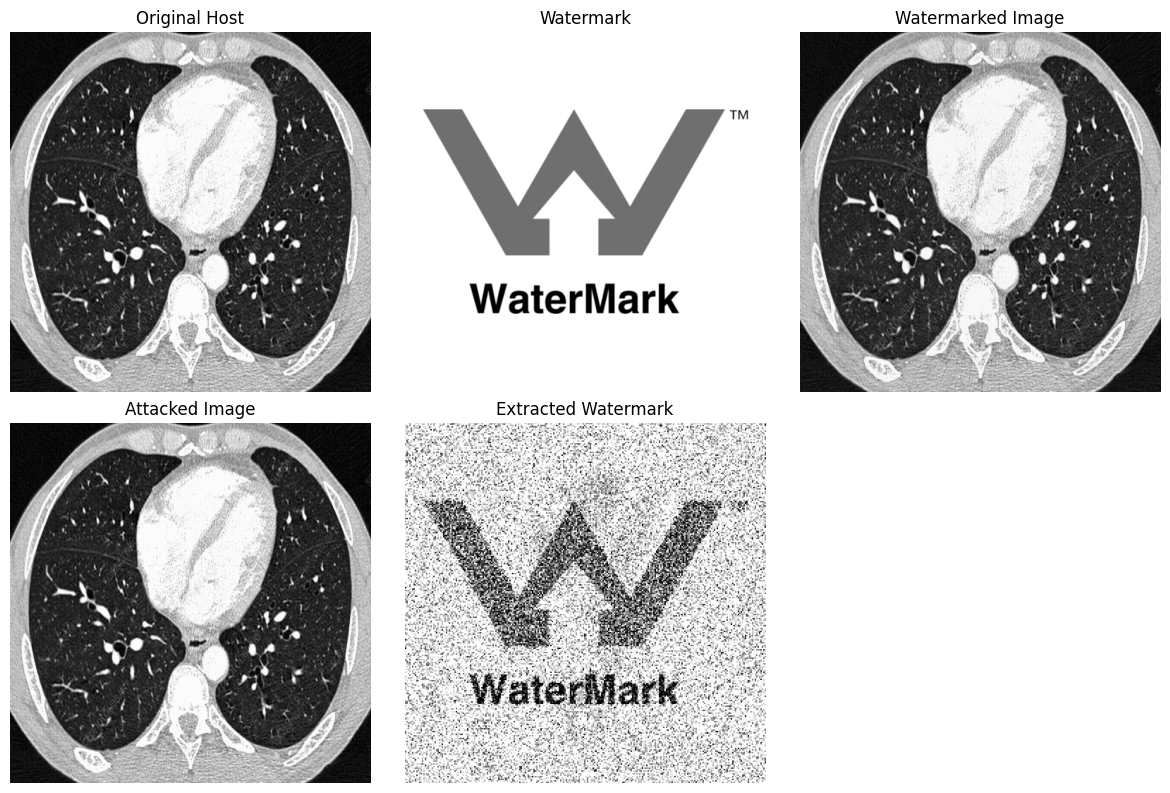

✅ Testing + visualization completed successfully!


In [7]:
# ===============================
# Watermark Testing + Visualization
# ===============================

import os
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_wavelets import DWTForward, DWTInverse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Embedder Model
# -------------------------------
class Embedder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16,32,3,2,1),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(32,1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return 0.002 + self.net(x) * 0.018

# -------------------------------
# Load Model
# -------------------------------
embedder = Embedder().to(device)
embedder.load_state_dict(torch.load("embedder_model.pth", map_location=device))
embedder.eval()

# -------------------------------
# DWT
# -------------------------------
dwt = DWTForward(J=1, wave='haar').to(device)
idwt = DWTInverse(wave='haar').to(device)

# -------------------------------
# Safe Image Loader
# -------------------------------
def load_gray(path, size=512):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"OpenCV failed to read image: {path}")

    img = cv2.resize(img, (size, size))
    img = torch.tensor(img / 255.0, dtype=torch.float32)
    img = img.unsqueeze(0).unsqueeze(0)
    return img.to(device)

# -------------------------------
# Embed & Extract
# -------------------------------
def embed_frequency(host, wm, alpha):
    Yl, Yh = dwt(host)

    LH = Yh[0][:,:,0,:,:]
    HL = Yh[0][:,:,1,:,:]
    HH = Yh[0][:,:,2,:,:]

    wm_resized = F.interpolate(wm, size=LH.shape[-2:], mode='bilinear')

    LH_emb = LH + alpha * wm_resized
    HL_emb = HL + alpha * wm_resized

    Yh_emb = torch.stack([LH_emb, HL_emb, HH], dim=2)
    wm_img = idwt((Yl, [Yh_emb]))

    return wm_img, wm_resized

def extract_frequency(wm_img, host, alpha):
    _, Yh_host = dwt(host)
    _, Yh_wm = dwt(wm_img)

    LH_host = Yh_host[0][:,:,0,:,:]
    HL_host = Yh_host[0][:,:,1,:,:]
    LH_wm = Yh_wm[0][:,:,0,:,:]
    HL_wm = Yh_wm[0][:,:,1,:,:]

    wm_ext = (LH_wm - LH_host + HL_wm - HL_host) / (2 * alpha)
    return wm_ext

def normalized_correlation(w1, w2):
    w1 = w1.flatten()
    w2 = w2.flatten()
    return (w1*w2).sum() / (torch.sqrt((w1**2).sum()*(w2**2).sum()) + 1e-8)

# -------------------------------
# Attack
# -------------------------------
def attack(img):
    img = img + torch.randn_like(img) * 0.01
    return torch.clamp(img, 0, 1)

# -------------------------------
# Image Paths
# -------------------------------
HOST_IMG = "host.png"
WM_IMG   = "watermark.png"

print("Host exists:", os.path.exists(HOST_IMG))
print("Watermark exists:", os.path.exists(WM_IMG))

# -------------------------------
# Load Images
# -------------------------------
host = load_gray(HOST_IMG)
wm = load_gray(WM_IMG, size=host.shape[-1])

# -------------------------------
# Embed
# -------------------------------
with torch.no_grad():
    alpha = embedder(host)
    wm_img, wm_resized = embed_frequency(host, wm, alpha)

# -------------------------------
# Attack
# -------------------------------
wm_img_attacked = attack(wm_img)

# -------------------------------
# Extract
# -------------------------------
with torch.no_grad():
    wm_ext = extract_frequency(wm_img_attacked, host, alpha)

# -------------------------------
# Metrics
# -------------------------------
host_np = host.squeeze().cpu().numpy()
wm_img_np = wm_img.squeeze().cpu().numpy()

print(f"PSNR: {psnr(host_np, wm_img_np):.2f}")
print(f"SSIM: {ssim(host_np, wm_img_np, data_range=1.0):.4f}")
print(f"NC: {normalized_correlation(wm_resized, wm_ext):.4f}")

# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("Original Host")
plt.imshow(host_np, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Watermark")
plt.imshow(wm.squeeze().cpu().numpy(), cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Watermarked Image")
plt.imshow(wm_img_np, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Attacked Image")
plt.imshow(wm_img_attacked.squeeze().cpu().numpy(), cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Extracted Watermark")
plt.imshow(np.clip(wm_ext.squeeze().cpu().numpy(), 0, 1), cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# -------------------------------
# Save Outputs
# -------------------------------
cv2.imwrite("watermarked.png", (wm_img_np * 255).astype(np.uint8))
cv2.imwrite(
    "extracted_watermark.png",
    (np.clip(wm_ext.squeeze().cpu().numpy(), 0, 1) * 255).astype(np.uint8)
)

print("✅ Testing + visualization completed successfully!")
